# TensorFlow 2.0

In [2]:
from glob import glob

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

import matplotlib.pyplot as plt
%matplotlib inline

## Hyperparameter Tunning

In [3]:
num_epochs = 10
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

## Build Model

In [4]:
inputs = layers.Input(input_shape)
net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [5]:
# Model is the full model w/o custom layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='categorical_crossentropy',  # Loss Function 
              metrics=['accuracy'])  # Metrics / Accuracy

# Data Preprocess

In [6]:
import os

In [9]:
train_paths = glob(r'C:\Users\LG\Deep_Learning_Study\Tensorflow\dataset\cifar\train\*.png')
test_paths = glob(r'C:\Users\LG\Deep_Learning_Study\Tensorflow\dataset\cifar\test\*.png')

In [12]:
path= train_paths[0]
path

'C:\\Users\\LG\\Deep_Learning_Study\\Tensorflow\\dataset\\cifar\\train\\0_frog.png'

In [15]:
def get_class_name(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    return lbl_name

In [16]:
path, get_class_name(path)

('C:\\Users\\LG\\Deep_Learning_Study\\Tensorflow\\dataset\\cifar\\train\\0_frog.png',
 <tf.Tensor: id=477, shape=(), dtype=string, numpy=b'frog'>)

In [ ]:
class_names = [get_class_name(path) for path in train_paths]
classes = tf.unique(class_names).y.numpy()

In [34]:
def onehot_encoding(label_names):
    onehot_encoding = tf.cast(classes == label_names, tf.uint8)
    return onehot_encoding

In [49]:
def read_dataset(path):
    # read image
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    
    # normalize
    image = tf.cast(image, tf.float32) / 32
    
    # read label
    class_name = get_class_name(path)
    label = onehot_encoding(class_name)
    return image, label

In [40]:
image, label = read_dataset(path)
image.shape, label.shape

(TensorShape([32, 32, 3]), TensorShape([10]))

In [41]:
image = tf.image.random_flip_left_right(image)
image = tf.image.random_flip_up_down(image)

### Data augmentation

In [42]:
def image_preprocess(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

In [45]:
transformed, label = image_preprocess(image, label)
transformed.shape

TensorShape([32, 32, 3])

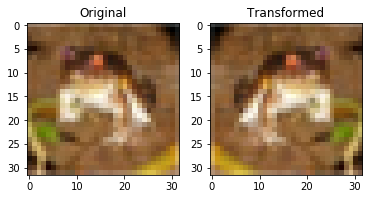

In [47]:
plt.subplot(121)
plt.imshow(image)
plt.title('Original')

plt.subplot(122)
plt.imshow(transformed)
plt.title('Transformed')

plt.show()

여러가지 augmentation 함수 확인
> ```python 
tf.image.
```

In [50]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(read_dataset)
train_dataset = train_dataset.map(image_preprocess) # trainform images
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size = len(train_paths))
train_dataset = train_dataset.repeat()

In [52]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(read_dataset)
# test set은 augmentation이 필요 없음
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=len(train_paths))
test_dataset = test_dataset.repeat()

## Training

In [55]:
steps_per_epoch  = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

In [ ]:
model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs
)

Epoch 1/10


---

#### Exercise

##### 1. data 불러오기

In [6]:
train_data = glob(r'C:\Users\LG\Deep_Learning_Study\Tensorflow\dataset\cifar\train\*.png')
test_data = glob(r'C:\Users\LG\Deep_Learning_Study\Tensorflow\dataset\cifar\test\*.png')

##### 2. data label 불러오기

In [13]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    return lbl_name

In [15]:
train_class = [get_label(path) for path in train_data]
test_class = [get_label(path) for path in test_data]

In [17]:
classes = tf.unique(train_class).y.numpy()
classes

array([b'frog', b'automobile', b'ship', b'cat', b'deer', b'airplane',
       b'truck', b'dog', b'bird', b'horse'], dtype=object)

##### 3. Onehot encoding으로 변환

In [19]:
classes == get_label(train_data[0])

<tf.Tensor: id=3840564, shape=(10,), dtype=bool, numpy=
array([ True, False, False, False, False, False, False, False, False,
       False])>

In [20]:
def onehot_encoding(image_label):
    onehot_encoding  = tf.cast(classes == image_label, tf.uint8)
    return onehot_encoding

##### 4. 이미지와 레이블 불러오기

In [21]:
def read_image_label(path):
    # read image
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    
    # normalize
    image = tf.cast(image, tf.float32) / 255.
    
    # read label
    label = get_label(path)
    label = onehot_encoding(label)
    
    return image, label

##### 5. image augmentation

In [22]:
def image_preprocessing(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

##### 6. dataset 제작

In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = train_dataset.map(read_image_label)
train_dataset = train_dataset.map(image_preprocessing)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(len(train_data))
train_dataset = train_dataset.repeat()

In [24]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_data)
test_dataset = test_dataset.map(read_image_label)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.shuffle(len(test_data))
test_dataset = test_dataset.repeat()

##### 7. Train

In [28]:
train_step = len(train_data) // batch_size
validation_step = len(test_data) // batch_size

In [ ]:
model.fit_generator(
    generator=train_dataset,
    steps_per_epoch=train_step,
    epochs=num_epochs,
    validation_data=test_dataset,
    validation_steps=validation_step
)

Epoch 1/10


---